In [2]:
import pandas as pd, numpy as np
import ccxt

# レート制限つきで初期化（安全）
ex = ccxt.binance({'enableRateLimit': True})

# BTC/USDT 15分足を取得（約3000本）
ohlcv = ex.fetch_ohlcv('BTC/USDT', timeframe='15m', limit=3000)

# DataFrame化＋JST（東京）に変換
df = pd.DataFrame(ohlcv, columns=['ts','open','high','low','close','vol'])
df['ts'] = pd.to_datetime(df['ts'], unit='ms', utc=True)
df = df.set_index('ts').tz_convert('Asia/Tokyo')

# 最後だけ確認
df.tail(3)


,open,high,low,close,vol
ts,,,,,
2025-09-20 17:30:00+09:00,115817.15,115888.81,115817.07,115884.06,37.28404
2025-09-20 17:45:00+09:00,115884.07,115884.07,115700.01,115701.43,67.70805
2025-09-20 18:00:00+09:00,115701.43,115715.76,115701.42,115714.99,1.94482


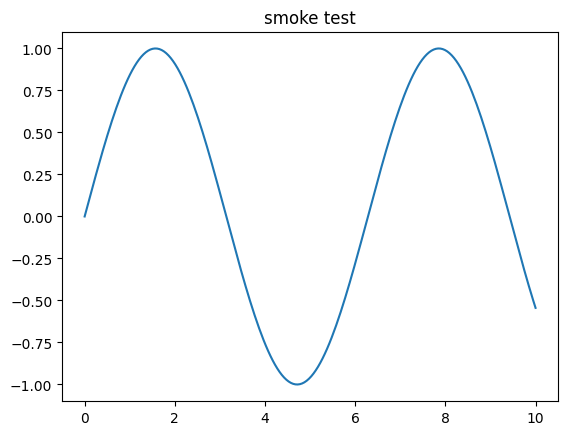

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np
x=np.linspace(0,10,200); plt.plot(x, np.sin(x)); plt.title("smoke test"); plt.show()


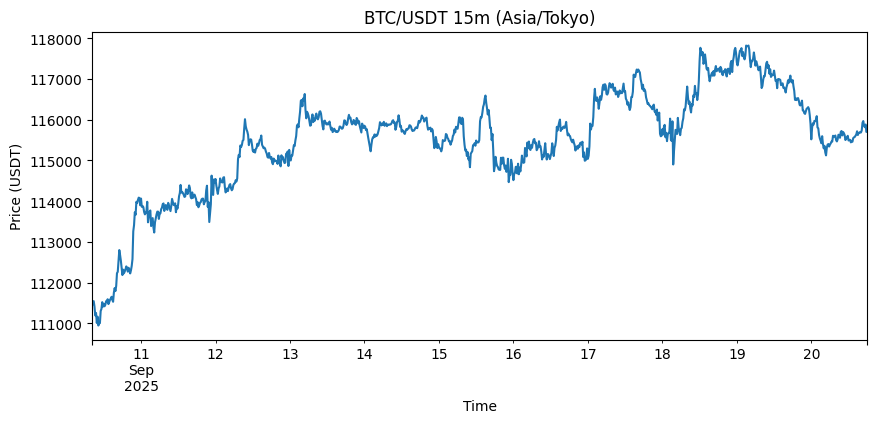

In [4]:
import matplotlib.pyplot as plt
df['close'].plot(figsize=(10,4), title='BTC/USDT 15m (Asia/Tokyo)')
plt.xlabel('Time'); plt.ylabel('Price (USDT)'); plt.show()


In [5]:
import numpy as np
short = df['close'].rolling(20).mean()
long  = df['close'].rolling(60).mean()

# 1=ロング, 0=ノーポジ（売りはまだ使わん）
sig = (short > long).astype(int)

# 対数リターン
ret = np.log(df['close']).diff()


In [6]:
# 未来を見ない：シグナルは1本遅らせて適用
gross = sig.shift(1).fillna(0) * ret

# 仮のコスト設定（片道）
fee  = 0.0010   # 手数料 0.10%
slip = 0.0002   # スリッページ 0.02%

# シグナル変化＝約定発生回数
turn = sig.diff().abs().fillna(0)
cost = turn.shift(1).fillna(0) * (fee + slip)

net = (gross - cost).dropna()
eq  = (1 + net).cumprod()


Sharpe≈ -11.51   MaxDD≈ -0.064   FinalEquity≈ 0.948


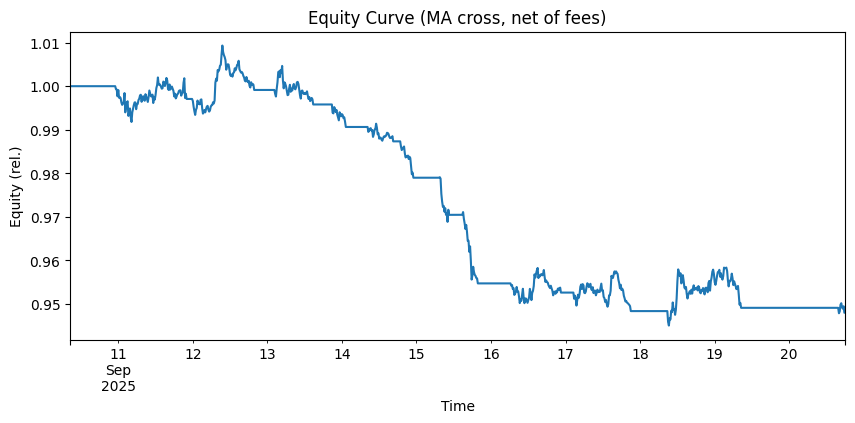

In [7]:
ann = np.sqrt(365*24*4)  # 15分足ざっくり年換算

sharpe = float(net.mean()/net.std()*ann) if net.std()!=0 else float('nan')
maxdd  = float((eq/eq.cummax()-1).min())
final  = float(eq.iloc[-1])

print(f"Sharpe≈ {sharpe:.2f}   MaxDD≈ {maxdd:.3f}   FinalEquity≈ {final:.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
eq.plot()
plt.title('Equity Curve (MA cross, net of fees)')
plt.xlabel('Time'); plt.ylabel('Equity (rel.)')
plt.show()


In [8]:
# df / 指標がちゃんと出来とるか
print("df:", df.shape, "range:", df.index.min(), "→", df.index.max())
print("close na:", df['close'].isna().sum())

short = df['close'].rolling(20).mean()
long  = df['close'].rolling(60).mean()
sig = (short > long).astype(int)
ret = np.log(df['close']).diff()

gross = sig.shift(1).fillna(0) * ret
fee, slip = 0.0010, 0.0002
turn = sig.diff().abs().fillna(0)
cost = turn.shift(1).fillna(0) * (fee+slip)
net = (gross - cost).dropna()
eq  = (1+net).cumprod()

print("sig unique:", np.unique(sig))
print("turn sum:", float(turn.sum()))
print("net len:", len(net), "eq len:", len(eq))
print("eq first/last:", float(eq.iloc[0]) if len(eq) else None, float(eq.iloc[-1]) if len(eq) else None)
net.describe(), eq.tail()


df: (1000, 5) range: 2025-09-10 08:15:00+09:00 → 2025-09-20 18:00:00+09:00
close na: 0
sig unique: [0 1]
turn sum: 23.0
net len: 999 eq len: 999
eq first/last: 1.0 0.9480853793814652


(count    999.000000
 mean      -0.000053
 std        0.000862
 min       -0.004528
 25%       -0.000271
 50%        0.000000
 75%        0.000120
 max        0.004180
 Name: close, dtype: float64,
 ts
 2025-09-20 17:00:00+09:00    0.949242
 2025-09-20 17:15:00+09:00    0.948924
 2025-09-20 17:30:00+09:00    0.949472
 2025-09-20 17:45:00+09:00    0.947974
 2025-09-20 18:00:00+09:00    0.948085
 Name: close, dtype: float64)

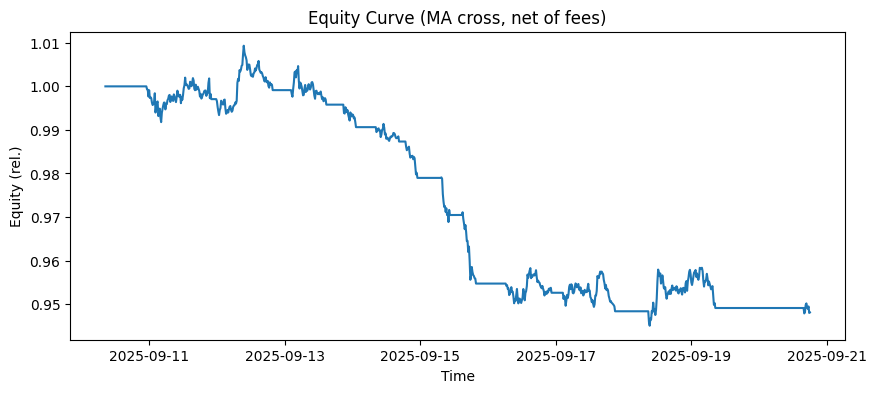

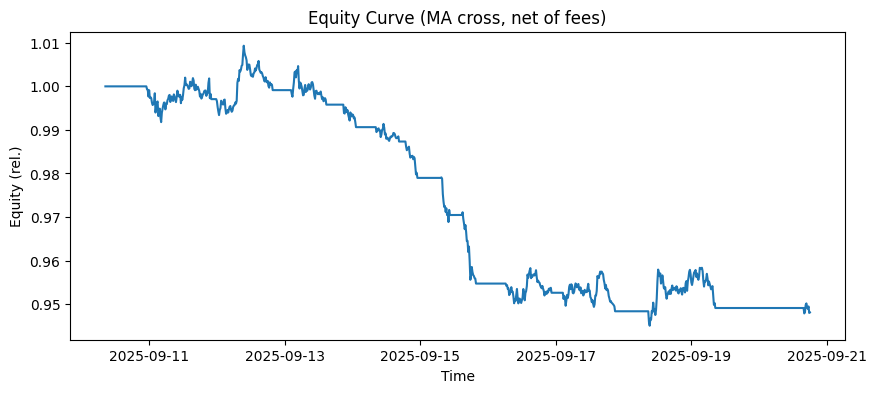

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

plt.close('all')
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(eq.index, eq.values)
ax.set_title('Equity Curve (MA cross, net of fees)')
ax.set_xlabel('Time'); ax.set_ylabel('Equity (rel.)')
display(fig)


OK: len=999  Sharpe≈-11.51  MaxDD≈-0.064  First≈1.000  Last≈0.948


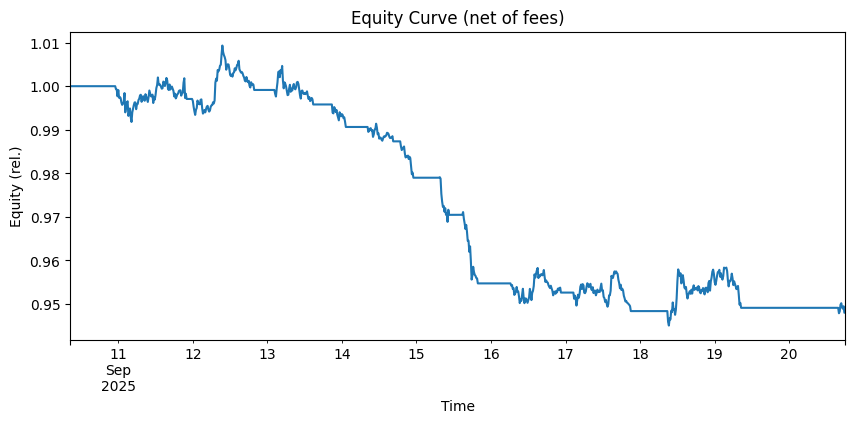

In [10]:
# 最終チェック（どっちか片方あればOK）
use_eq = eq if 'eq' in globals() and len(eq)>0 else (eq2 if 'eq2' in globals() and len(eq2)>0 else None)
use_net = net if 'net' in globals() and len(net)>0 else (net2 if 'net2' in globals() and 'net2' in globals() and len(net2)>0 else None)

assert use_eq is not None and use_net is not None, "資産曲線が空。前セルを上から順に再実行してみて。"

ann = (365*24*4)**0.5  # 15分足ざっくり年換算
sh  = float(use_net.mean()/use_net.std()*ann) if use_net.std()!=0 else float('nan')
dd  = float((use_eq/use_eq.cummax()-1).min())
print(f"OK: len={len(use_eq)}  Sharpe≈{sh:.2f}  MaxDD≈{dd:.3f}  First≈{use_eq.iloc[0]:.3f}  Last≈{use_eq.iloc[-1]:.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
use_eq.plot()
plt.title('Equity Curve (net of fees)'); plt.xlabel('Time'); plt.ylabel('Equity (rel.)')
plt.show()
